# Deep Q-Network Route Finder

Here in this jupyter notebook, we will have some fun with using reinforcement learning to find safe routes across the ice.
This notebook draws a lot of inspiration from Open AI's [FrozenLake](https://gym.openai.com/envs/FrozenLake8x8-v0/) gym environment.
Really, how nice of them to have a well crafted toy problem already thought out for us!

Specifically and technically, we will train a Deep Q-Network in Keras/Tensorflow to help us decide safe routes across slippery ice!
Later, we will move on to applying this safe navigation tool to our crevasse avoidance problem.

References:
- Open AI [gym](https://github.com/openai/gym) 
- [Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)
- [Simple Reinforcement Learning with Tensorflow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df)
- [Frozen Lake github gist using Keras](https://gist.github.com/ceshine/eeb97564c21a77b8c315179f82b3fc08)

In [1]:
# Import all the necessary libraries
import os
import sys
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  #set to see only the first gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
warnings.simplefilter(action = "ignore", category = FutureWarning)

#import gym
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import keras
import tensorflow as tf

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Mar 29 2018, 23:19:37) 
Numpy        : 1.14.2
Keras        : 2.1.5
Tensorflow   : 1.4.1


'/device:GPU:0'

## Design Keras Model to fit into Q-Network

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

In [3]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Flatten, Dense, Input, SeparableConv2D
from keras.layers.core import Activation, Flatten, Dropout, Reshape
#from rl.agents.dqn import DQNAgent
#from rl.policy import EpsGreedyQPolicy
#from rl.memory import SequentialMemory

In [4]:
def keras_convnet(input_shape=(4,4,2)):
    """
    The Keras Convolutional Network that parses the incoming pixel data.
    Consists of 3 Convolutional Layers, and 2 Dense Layers, plus 1 softmax output layer
    Note that we use SeparableConv2D layers ala MobileNets for memory efficiency
    
    Inputs:
    input_shape -- shape of the input tensor, (height, width, channels)
    
    Outputs:
    model -- keras.models.Model instance
    
    """
    inp = Input(shape=input_shape)
    
    X = SeparableConv2D(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', activation='relu', use_bias=False)(inp)
    X = SeparableConv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', use_bias=False)(X)
    X = SeparableConv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu', use_bias=False)(X)
    X = Flatten()(X)
    X = Dense(units=256, activation='relu', use_bias=False)(X)
    X = Dense(units=4, activation='softmax')(X)
    
    model = Model(inputs=inp, outputs=X) 
    
    return model
print(keras_convnet().summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 4, 2)           0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 4, 4, 32)          96        
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 4, 4, 64)          2336      
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 4, 4, 64)          4352      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262144    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total para

# Pure numpy implementation of Open AI Frozen Lake, plus a Keras Deep Q-network

### Helper function to convert integer to a 2D grid location

In [5]:
def int_to_grid(integer:int, grid_shape=(4,4)):
    """
    Function to map an integer to it's 2D grid location
    
    E.g. to place the integer 5 in a 4x4 (height*width) grid
    
            0000
    5   ->  0100
            0000
            0000
            
    Steps:
    1) np.prod(grid_shape) i.e. 4*4=16
    2) np.identity(16)[integer:integer+1] i.e. output something like [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    3) np.reshape(grid_shape) i.e. output the grid form of the above
    """
    assert(len(grid_shape) == 2)  #numpy array shape must be (height, width) i.e. 2 dimensional
    return np.identity(np.prod(grid_shape))[integer:integer+1].reshape(grid_shape)

### The player step left, down, right, up dynamics

In [6]:
def player_step(old_position:np.array, action:int):
    """
    Take a step somewhere, unless you'll go through the wall!
    
    Inputs:
    old_position -- a (height, width) shaped numpy array of 0s with a 1 marking the player position
    action -- an integer from 0 to 3 representing either Left, Down, Right, Up
    
    Outputs:
    new_position -- a (height, width) shaped numpy array of 0s with a 1 marking the player position
    
    Example taking a step Right:
    
           old_position                        new_position  
    array([[0., 0., 0., 0.],            array([[0., 0., 0., 0.],
           [0., 1., 0., 0.],    ----\          [0., 0., 1., 0.],
           [0., 0., 0., 0.],    ----/          [0., 0., 0., 0.],
           [0., 0., 0., 0.]])                  [0., 0., 0., 0.]])
    """
    actionKeys = {0:"Left <-", 1:"Down v", 2:"Right ->", 3:"Up ^"}
    grid_shape = old_position.shape  #(height, width)
    position = np.argmax(old_position)
    
    assert(len(old_position.shape) == 2)  #numpy array shape must be (height, width) i.e. 2 dimensional
    
    if actionKeys[action] == 'Left <-':
        #print('Going Left')
        #move left unless you are at the left wall
        new_pos = position - 1 if (position)%grid_shape[1] != 0 else position
    
    if actionKeys[action] == 'Down v':
        #print('Going Down')
        #move down unless you are at the bottom wall
        new_pos = position + grid_shape[0] if position + grid_shape[0] < np.prod(grid_shape) else position
    
    if actionKeys[action] == 'Right ->':
        #print('Going Right')
        #move right unless you are at the right wall
        new_pos = position + 1 if (position+1)%grid_shape[1] != 0 else position

    if actionKeys[action] == 'Up ^':
        #print('Going Up')
        #move up unless you are at the upper wall
        new_pos = position - grid_shape[0] if position - grid_shape[0] > 0 else position
    
    assert(new_pos in range(np.prod(grid_shape)))  #final check to see that we are within the grid range
    new_position = int_to_grid(new_pos, grid_shape=grid_shape)  #change our integer representation to grid format
    
    return new_position

### Colorful plot of player position and map grid

In [7]:
def plot_player_and_map(player_position, map_grid):
    """
    Matplotlib function to plot the player position on the left
    and the map_grid position on the right
    """
    assert(player_position.shape == map_grid.shape)
    
    fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(5,5))
    axarr[0, 0].imshow(X=player_position, cmap='winter')
    axarr[0, 1].imshow(X=-map_grid, cmap='BrBG')
    
    return plt.show()

### Initialize some environment variables and train the Deep Q-Network!

In [8]:
# Environment variables, replicated from https://gym.openai.com/envs/FrozenLake-v0/
actionKeys = {0:"Left <-", 1:"Down v", 2:"Right ->", 3:"Up ^"}
'''
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)

"SFFFFFFF",
"FFFFFFFF",
"FFFHFFFF",
"FFFFFHFF",
"FFFHFFFF",
"FHHFFFHF",
"FHFFHFHF",
"FFFHFFFG"
'''
map_grid = np.array([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 5.0, 0.0, 5.0],
                     [0.0, 0.0, 0.0, 5.0],
                     [5.0, 0.0, 0.0, -5.]], dtype=np.float)  #note that our map is inverse coded so -ve values are good and +ve values are bad!

map_grid = np.array([[.01, .01, .01, .01, .01, .01, .01, .01],
                     [.01, .01, .01, .01, .01, .01, .01, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, .01],
                     [.01, .01, .01, .01, .01, 5.0, .01, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, .01],
                     [.01, 5.0, 5.0, .01, .01, .01, 5.0, .01],
                     [.01, 5.0, .01, .01, 5.0, .01, 5.0, .01],
                     [.01, .01, .01, 5.0, .01, .01, .01, -5.]], dtype=np.float)


#Hyperparameters
epsilon = 1.00       #Exploration setting between 0 and 1, where 0 is don't explore and 1 is explore please!
gamma = 0.99         #Future discount factor between 0 and 1, where 0 means care only about now, and 1 means I care alot about the future!

#Session parameters
num_episodes = 3500  #how many episodes i.e. 'games' we will train our network on
status_print = 500   #the number of episodes that elapse before we print some message
rewardList = []
stepsList = []

### Initialize Deep Q-Network model parameters

In [9]:
# DQN model parameters
model = keras_convnet(input_shape=(map_grid.shape+(2,)))
#policy = EpsGreedyQPolicy(eps=0.1)
#nb_actions = env.action_space.n
#memory = SequentialMemory(limit=10000, window_length=4)

# DQN runtime parameters
def sum_squared_loss(yTrue, yPred):
    return K.sum(K.square(yTrue - yPred))
loss = sum_squared_loss
optimizer = keras.optimizers.Adam(lr=0.001)

# Compile keras model
model.compile(loss=loss, optimizer=optimizer)

### **Train the Deep Q-Network iteratively here**

Walkthrough in an ideal world (read: nicely tuned model):

Results will start off quite randomly due to high epsilon value resulting in high exploration.
There tends to be low reward score and high number of steps at this early stage.

Later on, you should start to notice the average number of steps decreasing, and perhaps a few high reward spikes when the agent reached the goal.
Around this middle stage, those high reward spikes will tend to be correlated with high number of steps.

Nearing the end, the Deep Q-Network should make less mistakes falling in the hole, i.e. have a reward score tending towards zero.
Finally, the model learns the right route across the map_grid, and you get high reward scores with a minimal number of steps.

Begin training Deep Q-Network!! Status update will be shown every 500 episodes
Step: 0 to 500, with epsilon: 0.9500000000000055
Q_values: [[ 0.41384807  0.34009737 -4.7315288   0.23415905]]


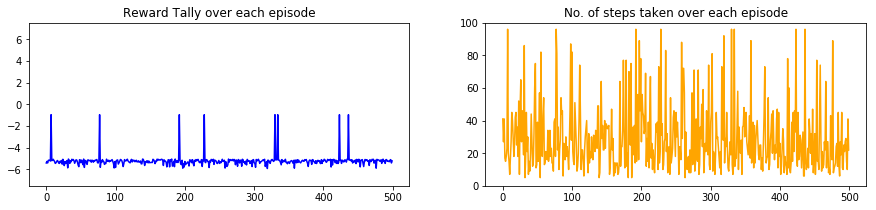

Step: 500 to 1000, with epsilon: 0.880000000000011
Q_values: [[ 0.3398721   0.26832885 -4.368952    0.39179447]]


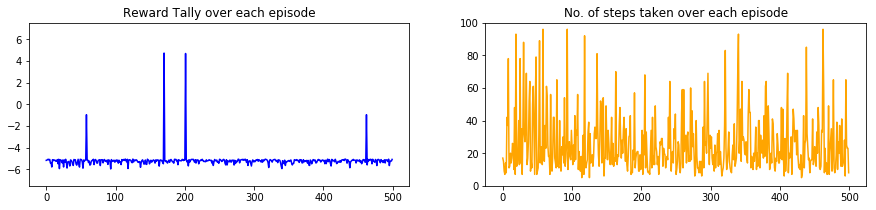

Step: 1000 to 1500, with epsilon: 0.8200000000000165
Q_values: [[ 0.2826293   0.40068224 -4.566419    0.31479573]]


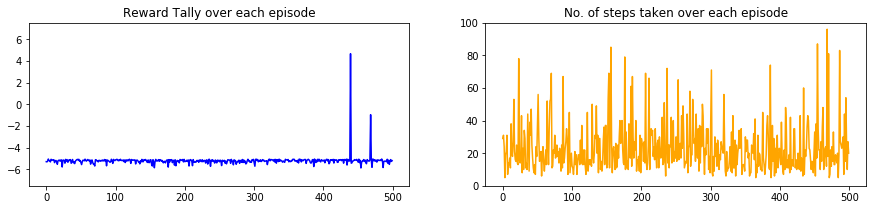

Step: 1500 to 2000, with epsilon: 0.740000000000022
Q_values: [[ 5.3819185e-01 -4.6158032e+00  6.5027940e-05  4.6165642e-01]]


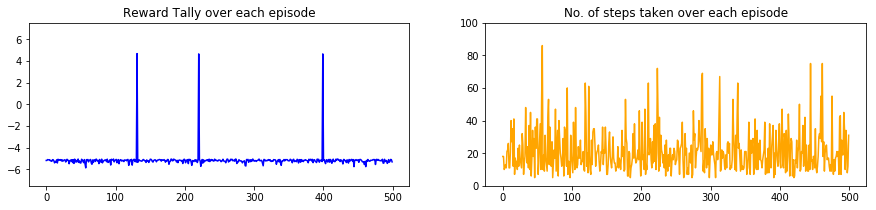

Step: 2000 to 2500, with epsilon: 0.6400000000000274
Q_values: [[ 0.16719614 -4.7016754   0.3051769   0.48966426]]


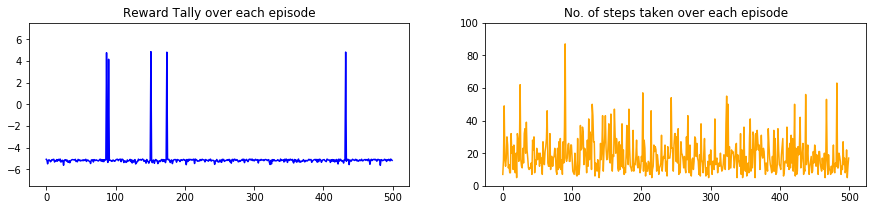

Step: 2500 to 3000, with epsilon: 0.5400000000000329
Q_values: [[ 0.32786235 -4.620867    0.51495314  0.1571573 ]]


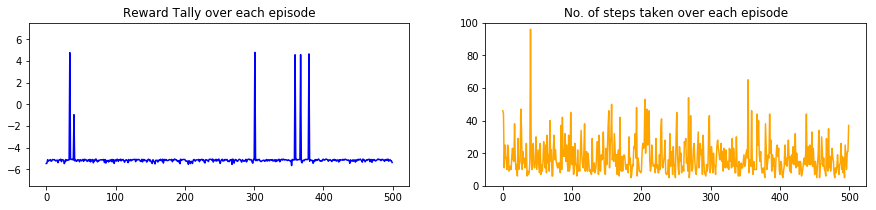

Step: 3000 to 3500, with epsilon: -3.119999999999965
Q_values: [[2.3471511e-16 5.9471455e+00 1.6303053e-08 2.0219968e-09]]


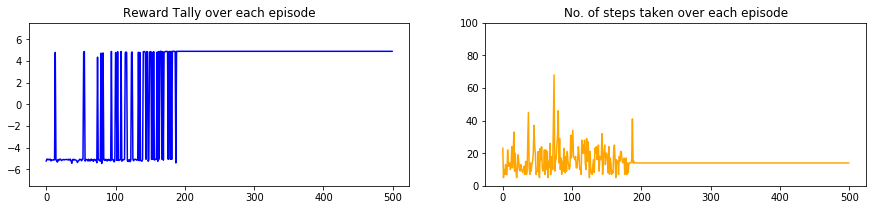

Percent of succesful episodes: 0.10771428571428572%


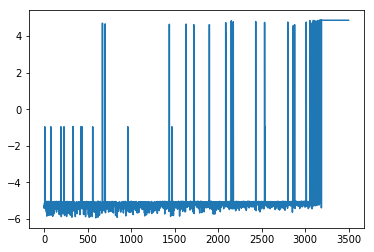

In [10]:
print(f"Begin training Deep Q-Network!! Status update will be shown every {status_print} episodes")
for i in range(1, num_episodes+1):
#for i in range(1):  #use if you only want to see one episode!
    player_position = int_to_grid(0, grid_shape=map_grid.shape)                #we start the player at the topleft corner of our map_grid
    current_state = np.stack([np.stack([player_position, map_grid], axis=-1)])  #stack the player_position array and map_grid array channel/depth-wise
    assert(current_state.shape == (1,map_grid.shape[0],map_grid.shape[1],2))    #check that our input current_state has shape (batch_size, rows, cols, channels)
    rewardTally = 0  #start reward Score at 0
    stepsTaken = 0  #counter in case our agent does too many stupid moves
    while stepsTaken < 96:    #limit the number of moves our agent can take to 96
        stepsTaken += 1
        
        #########################################################################
        #Our Deep Q-Network takes an input state (x) of the environment and
        #predicts an output list of Q-values (y) representing the 'q'uality of
        #the actions we can take to move the player around the map grid        
        
        #########################################################################
        ## Feed current state into Deep Q-Network
        current_state_Q_values = model.predict(x=current_state, batch_size=1)    #Use our neural network to get the Q values for each possible move given the current player position and map_grid
        #print(current_state_Q_values)                                           #outputs the Q values for our possible moves left, down, right, up as an array e.g. [[0.23, 0.22, 0.24, 0.26]]
        
        ## Decide what action to perform based on current_state_Q_values, and randomize with epsilon
        action = np.argmax(current_state_Q_values)                               #find the maximum/greatest Q value to decide what action to take
        if np.random.rand(1) < epsilon:                                          #if some random number is less than our epsilon value
            action = int(np.random.uniform(low=0, high=4))                       #we get a new action randomly from a uniform distribution!
        #print(actionKeys[action])
        
        ## Take a step towards somewhere
        player_position = player_step(old_position=player_position, action=action)
        #print(player_position)  #uncomment to see player position!
        
        ## Get new future state (stack of player_postion and map_grid representing our observation of the environment) and reward associated with it
        future_state = np.stack([np.stack([player_position, map_grid], axis=-1)])
        reward = -map_grid.ravel()[np.argmax(player_position)]                    #note that we do a negative here, because dangerous holes are mapped +ve in our map
        rewardTally += reward
        #print(rewardTally)
        
        #########################################################################
        ## Feed the future state into Deep Q-Network and get max Q value from it
        future_state_Q_values = model.predict(x=future_state, batch_size=1)
        future_state_max_Q = np.max(future_state_Q_values)
        #print(future_state_max_Q)
        
        ## Implement Bellman equation here!! Q(s,a) = r + γ(max(Q(s’,a’))
        #Basically, the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected
        target_Q = current_state_Q_values                       #set our target to the current_state first
        target_Q[0,action] = reward + gamma*future_state_max_Q  #replace the single Q-value at the index position of the action taken
        
        ## Retrain our Keras Deep Q-Network to learn this new target Q value
        model.fit(x=current_state, y=target_Q, verbose=0, batch_size=1)

        ## Check if we fell in the hole, else continue
        if rewardTally <= -5.0:
            break
        
        ## Check if we are done (reached goal), otherwise continue
        elif rewardTally > 0:
            epsilon = epsilon - (0.01)  #Reduce (by hardcoded amount) epsilon value, i.e. the chance of random action as we train the model.
            break
        
        ## Set the next current_state as our current future_state
        current_state = future_state
    
    ## After finishing an episode...
    epsilon = epsilon - (0.0001)  #Reduce (by hardcoded amount) epsilon value, i.e. the chance of random action as we train the model.
    rewardList.append(rewardTally) #we append the rewardTally for the episode to the rewardList
    stepsList.append(stepsTaken)
    
    ## Some print information
    if i%status_print==0:
        print(f"Step: {i-status_print} to {i}, with epsilon: {epsilon}")
        print("Q_values:", current_state_Q_values)
        fig, axarr = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(15,3))
        axarr[0, 0].plot(rewardList[-status_print:], color='blue') #plot to see e.g. last 500 rewardTallies
        axarr[0, 0].set_title('Reward Tally over each episode')
        axarr[0, 0].set_ylim([-7.5,7.5])
        axarr[0, 1].plot(stepsList[-status_print:], color='orange')  #plot to see e.g. last 500 number of steps taken
        axarr[0, 1].set_title('No. of steps taken over each episode')
        axarr[0, 1].set_ylim([0,100])
        plt.show()

#Show final score
success = len([r for r in rewardList if r >= 4])   #when we reached the goal
#failure = len([r for r in rewardList if r == 0])  #when we reached nowhere
epicfail = len([r for r in rewardList if r <= -4]) #when we dropped into a hole

print("Percent of succesful episodes: " + str(success/num_episodes) + "%")
plt.plot(rewardList[-num_episodes:])
plt.show()

### Save the DQN model!

In [11]:
model.save_weights(filepath='model/weights/dqn-model-weights.hdf5')

### See how our player does

In [12]:
model = keras_convnet(input_shape=(map_grid.shape+(2,)))  #reinstantiate our model
model.load_weights(filepath='model/weights/dqn-model-weights.hdf5')  #reload the saved dqn model weights

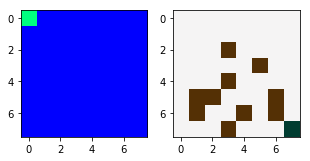

In [13]:
player_position = int_to_grid(0, grid_shape=map_grid.shape)   #we start the player at the topleft corner of our map_grid
plot_player_and_map(player_position=player_position, map_grid=map_grid)

In [14]:
current_state = np.stack([np.stack([player_position, map_grid], axis=-1)])
current_state_Q_values = model.predict(x=current_state, batch_size=1)
current_state_Q_values

array([[0.01881609, 0.75180024, 0.13323337, 0.09615022]], dtype=float32)

Down v


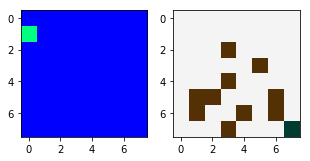

Down v


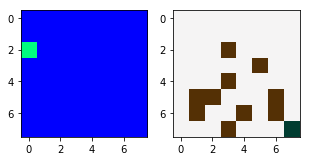

Right ->


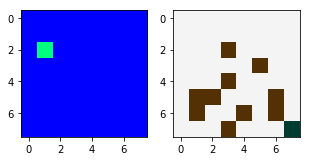

Right ->


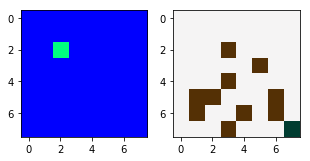

Down v


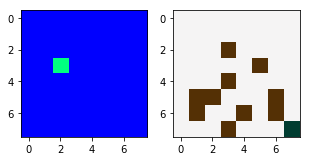

Right ->


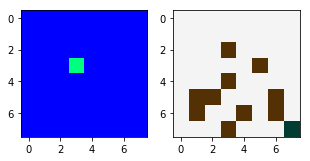

Right ->


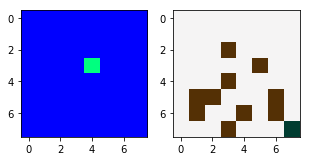

Down v


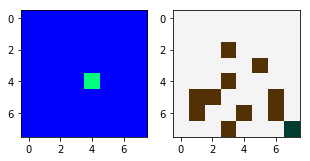

Right ->


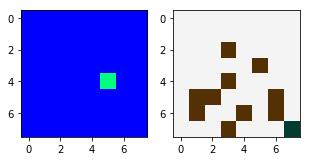

Right ->


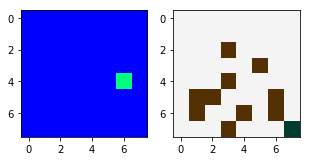

Right ->


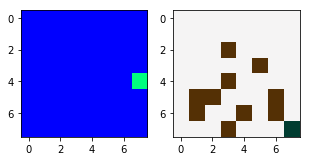

Down v


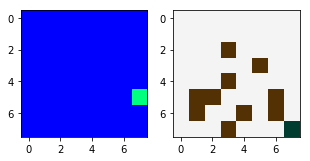

Down v


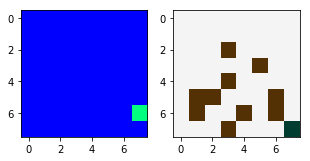

Down v


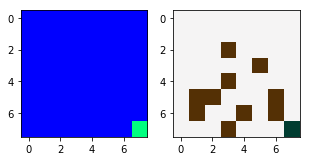

In [15]:
for i in range(14):  #take 14 steps and see if our player reaches the goal!
    current_state = np.stack([np.stack([player_position, map_grid], axis=-1)])
    current_state_Q_values = model.predict(x=current_state, batch_size=1)
    action = np.argmax(current_state_Q_values)
    print(actionKeys[action])
    player_position = player_step(old_position=player_position, action=action)
    plot_player_and_map(player_position=player_position, map_grid=map_grid)